# Solución | Tarea 2

In [ ]:
import csv
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score
import seaborn as sns


## Regresión

Basado en las condiciones del estudiantes vamos a predecir el puntaje que tendrá en las pruebas del saber en lectura critica “PUNT_GLOBAL”.

### 1. Realizar la exploración de los datos correlación, scatter plots, boxplots e histogramas

#### 1.1 ¿Qué variables son importantes para predecir el valor?

Voy a separar algunas columnas irrelevantes

In [ ]:
est_train_raw = pd.read_csv("data/training_pruebas.csv", low_memory=False)

In [ ]:
columnas_a_eliminar = [
    "ESTU_TIPODOCUMENTO", "ESTU_NACIONALIDAD", "PERIODO", "ESTU_CONSECUTIVO", "ESTU_ESTUDIANTE", "ESTU_PAIS_RESIDE",
    "ESTU_DEPTO_RESIDE", "ESTU_MCPIO_RESIDE", "ESTU_ESTADOCIVIL", "ESTU_TIPODOCUMENTOSB11", "FAMI_EDUCACIONPADRE", "FAMI_EDUCACIONMADRE",
    "FAMI_TRABAJOLABORPADRE", "FAMI_TRABAJOLABORMADRE", "FAMI_CUANTOSCOMPARTEBAÑO",
    "ESTU_PRESENTACIONCASA", "ESTU_PRESENTACIONSABADO", "INST_NOMBRE_INSTITUCION", "ESTU_PRGM_ACADEMICO", "GRUPOREFERENCIA",
    "ESTU_PRGM_MUNICIPIO", "ESTU_PRGM_DEPARTAMENTO", "ESTU_NUCLEO_PREGRADO", "ESTU_NUCLEO_PREGRADO_1",
    "ESTU_INST_MUNICIPIO", "ESTU_INST_DEPARTAMENTO", "INST_CARACTER_ACADEMICO", "INST_ORIGEN", "ESTU_MCPIO_PRESENTACION",
    "ESTU_DEPTO_PRESENTACION", "ESTU_ESTADOINVESTIGACION", "ESTU_COD_RESIDE_DEPTO", "ESTU_COD_RESIDE_MCPIO",
    "ESTU_SNIES_PRGMACADEMICO", "ESTU_PRGM_CODMUNICIPIO", "ESTU_INST_CODMUNICIPIO", "ESTU_COD_MCPIO_PRESENTACION", "ESTU_COD_DEPTO_PRESENTACION"
]

# Filtrar el conjunto de datos eliminando las variables no relevantes
datos_entrenamiento = datos_entrenamiento_original.drop(columns=columnas_a_eliminar)

#### 1.2 Existen nulos?, ¿cómo se deben imputar?

In [ ]:
numeric_variables = ["ESTU_INSE_INDIVIDUAL", "ESTU_NSE_INDIVIDUAL", "ESTU_NSE_IES"]
text_variables = [columna for columna in datos_entrenamiento.columns if (columna not in numeric_variables) and (columna != "PUNT_GLOBAL")]

def procesar_datos_faltantes(dataset):
    datos_procesados = dataset.copy()
    promedio = datos_procesados[numeric_variables].mean()
    valor_frecuente = datos_procesados[text_variables].mode()

    # Reemplazar valores nulos en variables numéricas con el promedio
    for columna in datos_procesados[numeric_variables]:
        for indice, valor in enumerate(datos_procesados[columna]):
            if math.isnan(valor):
                datos_procesados.loc[indice, columna] = promedio[columna]

    # Reemplazar valores nulos en variables categóricas con el valor más frecuente
    datos_procesados[text_variables] = datos_procesados[text_variables].apply(
        lambda serie: serie.fillna(serie.value_counts().index[0])
    )

    return datos_procesados

datos_entrenamiento = procesar_datos_faltantes(datos_entrenamiento)

# Procesar valores faltantes en la variable objetivo
for indice, valor in enumerate(datos_entrenamiento["PUNT_GLOBAL"]):
    if math.isnan(valor):
        datos_entrenamiento.loc[indice, "PUNT_GLOBAL"] = datos_entrenamiento["PUNT_GLOBAL"].mean()numeric_variables = ["ESTU_INSE_INDIVIDUAL", "ESTU_NSE_INDIVIDUAL", "ESTU_NSE_IES"]
text_variables = [columna for columna in datos_entrenamiento.columns if (columna not in numeric_variables) and (columna != "PUNT_GLOBAL")]

def procesar_datos_faltantes(dataset):
    datos_procesados = dataset.copy()
    promedio = datos_procesados[numeric_variables].mean()
    valor_frecuente = datos_procesados[text_variables].mode()

    # Reemplazar valores nulos en variables numéricas con el promedio
    for columna in datos_procesados[numeric_variables]:
        for indice, valor in enumerate(datos_procesados[columna]):
            if math.isnan(valor):
                datos_procesados.loc[indice, columna] = promedio[columna]

    # Reemplazar valores nulos en variables categóricas con el valor más frecuente
    datos_procesados[text_variables] = datos_procesados[text_variables].apply(
        lambda serie: serie.fillna(serie.value_counts().index[0])
    )

    return datos_procesados

datos_entrenamiento = procesar_datos_faltantes(datos_entrenamiento)

# Procesar valores faltantes en la variable objetivo
for indice, valor in enumerate(datos_entrenamiento["PUNT_GLOBAL"]):
    if math.isnan(valor):
        datos_entrenamiento.loc[indice, "PUNT_GLOBAL"] = datos_entrenamiento["PUNT_GLOBAL"].mean()

#### 1.3 Crear dummy variables para incluirlas en la correlación

Primero voy a sanitizar algunas variables catégoricas, para no crear demasiados dummies

In [ ]:
def preparar_variables(dataset):

    # Calcular la edad de cada estudiante
    dataset["ESTU_FECHANACIMIENTO"] = pd.to_datetime(dataset["ESTU_FECHANACIMIENTO"], format="mixed", dayfirst=True, errors='coerce')
    fecha_actual = pd.to_datetime('today', format="%d/%m/%Y")
    dataset["ESTU_FECHANACIMIENTO"] = dataset["ESTU_FECHANACIMIENTO"].apply(
        lambda fecha: fecha_actual.year - fecha.year - ((fecha_actual.month, fecha_actual.day) < (fecha.month, fecha.day))
    )
    edad_promedio = dataset["ESTU_FECHANACIMIENTO"].mean()

    # Reemplazar valores nulos en edad
    for indice, valor in enumerate(dataset["ESTU_FECHANACIMIENTO"]):
        if str(valor) == 'nan':
            dataset.loc[indice, "ESTU_FECHANACIMIENTO"] = edad_promedio

    # Convertir variables categóricas a numéricas binarias

    # Convertir género (M: 0, F: 1)
    dataset["ESTU_GENERO"] = dataset["ESTU_GENERO"].apply(lambda g: 1 if g == 'F' else 0)

    # Convertir estudio en el exterior (NO: 0, SI: 1)
    dataset["ESTU_EXTERIOR"] = dataset["ESTU_EXTERIOR"].apply(lambda respuesta: 1 if respuesta == 'SI' else 0)

    # Convertir área de residencia (Area Rural: 0, Cabecera Municipal: 1)
    dataset["ESTU_AREARESIDE"] = dataset["ESTU_AREARESIDE"].apply(lambda area: 1 if area == 'Cabecera Municipal' else 0)

    # Convertir variables de pago de matrícula
    dataset["ESTU_PAGOMATRICULABECA"] = dataset["ESTU_PAGOMATRICULABECA"].apply(lambda resp: 1 if resp == 'Si' else 0)
    dataset["ESTU_PAGOMATRICULACREDITO"] = dataset["ESTU_PAGOMATRICULACREDITO"].apply(lambda resp: 1 if resp == 'Si' else 0)
    dataset["ESTU_PAGOMATRICULAPADRES"] = dataset["ESTU_PAGOMATRICULAPADRES"].apply(lambda resp: 1 if resp == 'Si' else 0)
    dataset["ESTU_PAGOMATRICULAPROPIO"] = dataset["ESTU_PAGOMATRICULAPROPIO"].apply(lambda resp: 1 if resp == 'Si' else 0)

    # Convertir variables de preparación académica
    dataset["ESTU_SIMULACROTIPOICFES"] = dataset["ESTU_SIMULACROTIPOICFES"].apply(lambda resp: 1 if resp == 'Si' else 0)
    dataset["ESTU_ACTIVIDADREFUERZOAREAS"] = dataset["ESTU_ACTIVIDADREFUERZOAREAS"].apply(lambda resp: 1 if resp == 'Si' else 0)
    dataset["ESTU_ACTIVIDADREFUERZOGENERIC"] = dataset["ESTU_ACTIVIDADREFUERZOGENERIC"].apply(lambda resp: 1 if resp == 'Si' else 0)

    # Convertir variables de posesiones familiares
    bienes_familiares = [
        "FAMI_TIENEINTERNET", "FAMI_TIENECOMPUTADOR", "FAMI_TIENELAVADORA",
        "FAMI_TIENEHORNOMICROOGAS", "FAMI_TIENESERVICIOTV", "FAMI_TIENEAUTOMOVIL",
        "FAMI_TIENEMOTOCICLETA", "FAMI_TIENECONSOLAVIDEOJUEGOS"
    ]

    for bien in bienes_familiares:
        dataset[bien] = dataset[bien].apply(lambda resp: 1 if resp == 'Si' else 0)

    # Convertir método del programa (PRESENCIAL: 0, DISTANCIA VIRTUAL: 1)
    dataset["ESTU_METODO_PRGM"] = dataset["ESTU_METODO_PRGM"].apply(lambda metodo: 1 if metodo == 'DISTANCIA VITUAL' else 0)

    # Convertir estado de privación de libertad
    dataset["ESTU_PRIVADO_LIBERTAD"] = dataset["ESTU_PRIVADO_LIBERTAD"].apply(lambda estado: 1 if estado == 'S' else 0)

# Aplicar transformaciones al conjunto de datos
preparar_variables(datos_entrenamiento)
print("Valores nulos: ", np.nonzero(pd.isnull(datos_entrenamiento)))
datos_entrenamiento

Nulos:  (array([], dtype=int64), array([], dtype=int64))


,ESTU_GENERO,ESTU_FECHANACIMIENTO,ESTU_EXTERIOR,ESTU_AREARESIDE,ESTU_TITULOOBTENIDOBACHILLER,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_PAGOMATRICULABECA,ESTU_PAGOMATRICULACREDITO,ESTU_PAGOMATRICULAPADRES,ESTU_PAGOMATRICULAPROPIO,...,ESTU_PAGOMATRICULA,ESTU_VLRULTIMOSEMESCURSADO,INST_COD_INSTITUCION,ESTU_NIVEL_PRGM_ACADEMICO,ESTU_METODO_PRGM,ESTU_PRIVADO_LIBERTAD,PUNT_GLOBAL,ESTU_INSE_INDIVIDUAL,ESTU_NSE_INDIVIDUAL,ESTU_NSE_IES
0,0,24.0,0,1,Bachiller académico,Entre 500 mil y menos de 1 millón,1,0,0,0,...,Familiares,Menos de 500 mil pesos,1202,UNIVERSITARIO,0,0,188,55.570156,3.000000,2
1,0,23.0,0,1,Bachiller académico,Entre 1 millón y menos de 2.5 millones,1,0,0,0,...,Becas o Subsidios,Menos de 500 mil pesos,2102,UNIVERSITARIO,0,0,140,38.105883,1.000000,2
2,1,28.0,0,1,Bachiller académico,Entre 1 millón y menos de 2.5 millones,1,0,0,0,...,Becas o Subsidios,Menos de 500 mil pesos,2102,UNIVERSITARIO,0,0,140,65.658631,4.000000,2
3,1,29.0,0,1,Bachiller académico,No pagó matrícula,1,0,1,0,...,Becas o Subsidios,No pago semestre,1218,UNIVERSITARIO,0,0,111,49.260729,2.000000,2
4,1,46.0,0,1,Bachiller académico,Entre 2.5 millones y menos de 4 millones,0,0,0,1,...,Propios,Entre 3 y 5 millones,2812,UNIVERSITARIO,1,0,135,55.138843,2.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111425,1,24.0,0,1,Bachiller técnico,No pagó matrícula,1,0,1,0,...,Familiares,Entre un millon y 3 millones de pesose,1107,UNIVERSITARIO,0,0,137,55.028124,2.678834,2
111426,1,24.0,0,1,Bachiller académico,Entre 4 millones y menos de 5.5 millones,1,0,1,0,...,Familiares,Entre 3 y 5 millones,1805,UNIVERSITARIO,0,0,161,63.619372,4.000000,3
111427,0,60.0,0,1,Bachiller académico,Entre 2.5 millones y menos de 4 millones,0,0,0,1,...,Creditos,Entre un millon y 3 millones de pesose,4702,UNIVERSITARIO,0,0,124,48.648902,2.000000,2
111428,1,23.0,0,1,Bachiller académico,Entre 4 millones y menos de 5.5 millones,0,1,0,0,...,Creditos,Entre 3 y 5 millones,1824,UNIVERSITARIO,0,0,142,52.877602,2.000000,4


In [ ]:
def estandarizar_variables(conjunto_datos):
    for indice, columna in enumerate(conjunto_datos.columns):
        desviacion = conjunto_datos[columna].std()
        if desviacion == 0:
            conjunto_datos[columna] = 0
        else:
            conjunto_datos[columna] = (conjunto_datos[columna] - conjunto_datos[columna].mean()) / desviacion

# Convertir variables categóricas a formato one-hot
datos_entrenamiento_codificados = pd.get_dummies(datos_entrenamiento)

# Aplicar estandarización a todas las variables
estandarizar_variables(datos_entrenamiento_codificados)

# Mostrar el conjunto de datos procesado
datos_entrenamiento_codificados

,ESTU_GENERO,ESTU_FECHANACIMIENTO,ESTU_EXTERIOR,ESTU_AREARESIDE,ESTU_PAGOMATRICULABECA,ESTU_PAGOMATRICULACREDITO,ESTU_PAGOMATRICULAPADRES,ESTU_PAGOMATRICULAPROPIO,ESTU_SIMULACROTIPOICFES,ESTU_ACTIVIDADREFUERZOAREAS,...,ESTU_PAGOMATRICULA_Creditos,ESTU_PAGOMATRICULA_Familiares,ESTU_VLRULTIMOSEMESCURSADO_Entre 3 y 5 millones,ESTU_VLRULTIMOSEMESCURSADO_Entre 5 y 7 millones,ESTU_VLRULTIMOSEMESCURSADO_Entre 500 mil y un millon de pesos,ESTU_VLRULTIMOSEMESCURSADO_Entre un millon y 3 millones de pesose,ESTU_VLRULTIMOSEMESCURSADO_Mas de 7 millones,ESTU_VLRULTIMOSEMESCURSADO_Menos de 500 mil pesos,ESTU_VLRULTIMOSEMESCURSADO_No pago semestre,ESTU_NIVEL_PRGM_ACADEMICO_UNIVERSITARIO
0,-1.141938,-0.707909,-0.123835,0.37177,1.534565,-0.617858,-0.834938,-0.942998,0.075645,0.098651,...,-0.547684,1.485369,-0.456533,-0.273497,-0.239647,-0.704445,-0.276743,2.582217,-0.453214,0
1,-1.141938,-0.851468,-0.123835,0.37177,1.534565,-0.617858,-0.834938,-0.942998,0.075645,0.098651,...,-0.547684,-0.673227,-0.456533,-0.273497,-0.239647,-0.704445,-0.276743,2.582217,-0.453214,0
2,0.875696,-0.133672,-0.123835,0.37177,1.534565,-0.617858,-0.834938,-0.942998,0.075645,0.098651,...,-0.547684,-0.673227,-0.456533,-0.273497,-0.239647,-0.704445,-0.276743,2.582217,-0.453214,0
3,0.875696,0.009887,-0.123835,0.37177,1.534565,-0.617858,1.197683,-0.942998,0.075645,0.098651,...,-0.547684,-0.673227,-0.456533,-0.273497,-0.239647,-0.704445,-0.276743,-0.387261,2.206445,0
4,0.875696,2.450393,-0.123835,0.37177,-0.651645,-0.617858,-0.834938,1.060439,0.075645,0.098651,...,-0.547684,-0.673227,2.190403,-0.273497,-0.239647,-0.704445,-0.276743,-0.387261,-0.453214,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111425,0.875696,-0.707909,-0.123835,0.37177,1.534565,-0.617858,1.197683,-0.942998,0.075645,0.098651,...,-0.547684,1.485369,-0.456533,-0.273497,-0.239647,1.419545,-0.276743,-0.387261,-0.453214,0
111426,0.875696,-0.707909,-0.123835,0.37177,1.534565,-0.617858,1.197683,-0.942998,0.075645,0.098651,...,-0.547684,1.485369,2.190403,-0.273497,-0.239647,-0.704445,-0.276743,-0.387261,-0.453214,0
111427,-1.141938,4.460221,-0.123835,0.37177,-0.651645,-0.617858,-0.834938,1.060439,0.075645,0.098651,...,1.825854,-0.673227,-0.456533,-0.273497,-0.239647,1.419545,-0.276743,-0.387261,-0.453214,0
111428,0.875696,-0.851468,-0.123835,0.37177,-0.651645,1.618480,-0.834938,-0.942998,0.075645,0.098651,...,1.825854,-0.673227,2.190403,-0.273497,-0.239647,-0.704445,-0.276743,-0.387261,-0.453214,0


#### 1.4 Crear una correlación, que variables tienen un efecto positivo en el puntaje y cuales un efecto negativo.

In [ ]:
est_train_dumm.corrwith(est_train_dumm["PUNT_GLOBAL"]).sort_values(ascending=False).iloc[1:]

/home/smorenova/Projects/EST_III_UCO/tarea2/src/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/smorenova/Projects/EST_III_UCO/tarea2/src/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ESTU_NSE_IES                                                         0.262818
ESTU_VALORMATRICULAUNIVERSIDAD_Más de 7 millones                     0.244534
ESTU_INSE_INDIVIDUAL                                                 0.238292
ESTU_NSE_INDIVIDUAL                                                  0.215721
ESTU_VLRULTIMOSEMESCURSADO_Mas de 7 millones                         0.213380
                                                                       ...   
ESTU_PAGOMATRICULAPROPIO                                            -0.165790
ESTU_VLRULTIMOSEMESCURSADO_Entre un millon y 3 millones de pesose   -0.185439
INST_COD_INSTITUCION                                                -0.205356
ESTU_FECHANACIMIENTO                                                -0.252666
ESTU_NIVEL_PRGM_ACADEMICO_UNIVERSITARIO                                   NaN
Length: 108, dtype: float64

Al realizar la correlación de cada variable contra PUNT_GLOBAL, se pueden observar las variables que tienen un efecto positivo en la parte superior; y las que tienen un efecto negativo en la parte inferior. El nivel socioeconómico es la variable que más influencia en el puntaje global.

<Figure size 300x100 with 0 Axes>

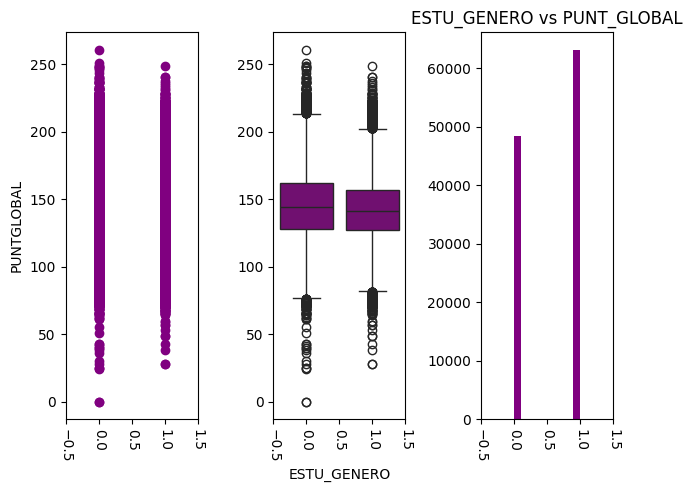

<Figure size 300x100 with 0 Axes>

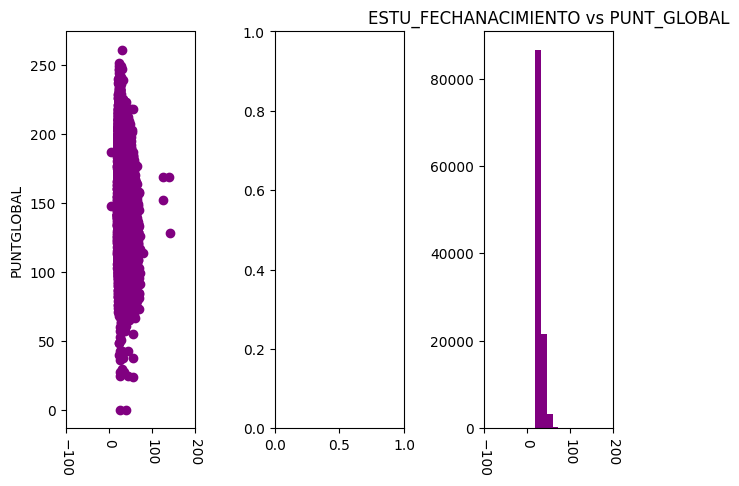

<Figure size 300x100 with 0 Axes>

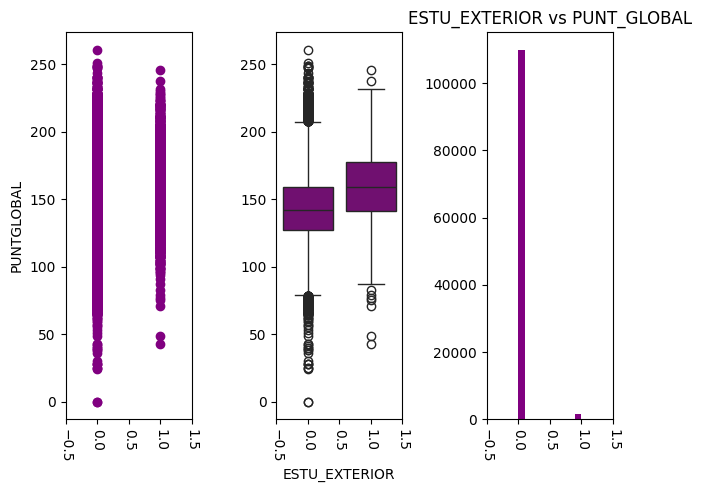

KeyboardInterrupt: 

<Figure size 300x100 with 0 Axes>

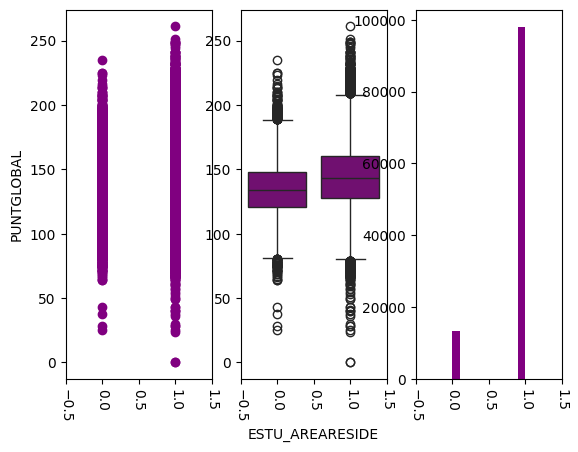

In [ ]:
for col in categorical_cols:

    d = plt.figure(figsize=(3,1))
    d, ax = plt.subplots(ncols=3)

    ax[0].scatter(est_train[col],est_train["PUNT_GLOBAL"], c="purple")
    ax[0].set_xticks(ax[0].get_xticks())
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-90)
    ax[0].set_ylabel("PUNTGLOBAL")

    if (col != "ESTU_FECHANACIMIENTO"):
        sns.boxplot(x=est_train[col], y=est_train["PUNT_GLOBAL"], ax=ax[1], color="purple")
        ax[1].set_xlabel(col)
        ax[1].set_ylabel("")
        ax[1].set_xticks(ax[0].get_xticks())
        ax[1].set_xticklabels(ax[0].get_xticklabels(), rotation=-90)

    ax[2].hist(est_train[col], color="purple")
    ax[2].set_xticks(ax[0].get_xticks())
    ax[2].set_xticklabels(ax[0].get_xticklabels(), rotation=-90)

    d.tight_layout()

    plt.title(f"{col} vs PUNT_GLOBAL")
    plt.show()

### 2. Divida los datos en training y testing

In [ ]:
x, y = est_train_dumm[[col for col in est_train_dumm.columns if col != "PUNT_GLOBAL"]], est_train["PUNT_GLOBAL"]
xr, xs, yr, ys = train_test_split(x, y, test_size=0.2, random_state=42)

#### 2.1 Aplique las transformaciones más importantes a los datos. (Hint calcular la edad basada en la fecha de nacimiento, agrupar variables categóricas con mucha cardinalidad en grupos).
[Ver 1.3](#13-crear-dummy-variables-para-incluirlas-en-la-correlación)

#### 2.2 Entrenar un modelos de regresión

In [ ]:
reg = LinearRegression()
reg.fit(xr, yr)

LinearRegression()

#### 2.3 ¿Cuál es el mejor R squared? Cuál es el MAPE y el MSE.

In [ ]:
yr_hat = reg.predict(xr)

def get_r2(true, pred):
    SSR, SST = sum((true-pred)**2), sum((true-np.mean(true))**2)
    R2 = 1 - (float(SSR))/SST
    return R2

def get_mse(true, pred):
    return (1/len(true))*sum((true-pred)**2)

def get_mape(true, pred):
    return (100/len(true)*sum(abs(pred-true)/true))

print("Training:")
print("R²   ", get_r2(yr, yr_hat))
print("MAPE ", get_mape(yr, yr_hat), "(Hay puntajes en 0)")
print("MSE  ", get_mse(yr, yr_hat))

Training:
R²    0.2564686189496751
MAPE  inf (Hay puntajes en 0)
MSE   408.4257366177803


### 3. Remueva las variables que nos son relevantes

[Ver 1.1](#11-qué-variables-son-importantes-para-predecir-el-valor)

### 4. Utilizando los datos de test medir el MAPE y el MSE de test. Qué tan diferentes son las métricas de training. (El menor error del grupo tiene un +1)

In [ ]:
ys_hat = reg.predict(xs)

print("Test:")
print("R²   ", get_r2(ys, ys_hat))
print("MAPE ", get_mape(ys, ys_hat), "(Hay puntajes en 0)")
print("MSE  ", get_mse(ys, ys_hat))

Test:
R²    0.2636236208663617
MAPE  inf (Hay puntajes en 0)
MSE   407.8028781116584


No hay mucha diferencia respecto al training.

### 5. Describa en palabras que dice el modelo cuales son los principales hallazgos.

El principal hallazgo es que el las variables seleccionadas no son buenas para explicar la variabilidad del puntaje global, ya que se obtuvo un valor un poco bajo.

In [ ]:
est_test_raw = pd.read_csv("data/test_pruebas.csv", low_memory=False)
est_test = est_test_raw.drop(columns=irrelevant_cols)
est_test = fix_nulls(est_test)
transform_data(est_test)
est_test_dumm = pd.get_dummies(est_test)
normalize(est_test_dumm)
est_test_dumm

,ESTU_GENERO,ESTU_FECHANACIMIENTO,ESTU_EXTERIOR,ESTU_AREARESIDE,ESTU_PAGOMATRICULABECA,ESTU_PAGOMATRICULACREDITO,ESTU_PAGOMATRICULAPADRES,ESTU_PAGOMATRICULAPROPIO,ESTU_SIMULACROTIPOICFES,ESTU_ACTIVIDADREFUERZOAREAS,...,ESTU_PAGOMATRICULA_Creditos,ESTU_PAGOMATRICULA_Familiares,ESTU_VLRULTIMOSEMESCURSADO_Entre 3 y 5 millones,ESTU_VLRULTIMOSEMESCURSADO_Entre 5 y 7 millones,ESTU_VLRULTIMOSEMESCURSADO_Entre 500 mil y un millon de pesos,ESTU_VLRULTIMOSEMESCURSADO_Entre un millon y 3 millones de pesose,ESTU_VLRULTIMOSEMESCURSADO_Mas de 7 millones,ESTU_VLRULTIMOSEMESCURSADO_Menos de 500 mil pesos,ESTU_VLRULTIMOSEMESCURSADO_No pago semestre,ESTU_NIVEL_PRGM_ACADEMICO_UNIVERSITARIO
0,0.873960,3.005523,-0.122216,0.362459,-0.653165,1.643914,-0.833058,-0.946695,0.075763,0.09706,...,1.853608,-0.675279,-0.454813,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0
1,-1.144175,-0.423926,-0.122216,0.362459,1.530951,-0.608282,-0.833058,-0.946695,0.075763,0.09706,...,1.853608,-0.675279,-0.454813,3.712968,-0.245202,-0.701277,-0.275324,-0.391896,-0.454123,0
2,0.873960,-0.281032,-0.122216,0.362459,-0.653165,-0.608282,-0.833058,-0.946695,0.075763,0.09706,...,-0.539469,-0.675279,-0.454813,-0.269317,-0.245202,-0.701277,-0.275324,-0.391896,2.201967,0
3,0.873960,0.290543,-0.122216,0.362459,-0.653165,-0.608282,1.200354,-0.946695,0.075763,0.09706,...,-0.539469,1.480816,-0.454813,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0
4,0.873960,0.290543,8.181928,0.362459,-0.653165,-0.608282,-0.833058,-0.946695,0.075763,0.09706,...,-0.539469,1.480816,-0.454813,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27853,0.873960,0.576330,-0.122216,0.362459,-0.653165,1.643914,-0.833058,1.056269,0.075763,0.09706,...,-0.539469,-0.675279,-0.454813,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0
27854,-1.144175,-0.709714,-0.122216,0.362459,-0.653165,1.643914,1.200354,-0.946695,0.075763,0.09706,...,-0.539469,-0.675279,2.198627,-0.269317,-0.245202,-0.701277,-0.275324,-0.391896,-0.454123,0
27855,0.873960,3.434205,-0.122216,0.362459,1.530951,-0.608282,-0.833058,-0.946695,0.075763,0.09706,...,1.853608,-0.675279,-0.454813,-0.269317,-0.245202,-0.701277,-0.275324,2.551605,-0.454123,0
27856,0.873960,-0.138139,-0.122216,0.362459,-0.653165,-0.608282,1.200354,1.056269,0.075763,0.09706,...,-0.539469,-0.675279,-0.454813,-0.269317,-0.245202,1.425919,-0.275324,-0.391896,-0.454123,0


In [ ]:
est_test_pred = reg.predict(est_test_dumm)
output = pd.DataFrame(est_test_pred, columns=["GLOBAL_SCORE"])

with open("output/Regression.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id","GLOBAL_SCORE"])
    for i, val in enumerate(np.array(output["GLOBAL_SCORE"])):
        writer.writerow([est_test_raw["ESTU_CONSECUTIVO"][i],val])

output

,GLOBAL_SCORE
0,123.656862
1,156.521897
2,149.964374
3,132.678944
4,160.248452
...,...
27853,136.277543
27854,153.967162
27855,130.799047
27856,147.414745


## Crear un modelo de KNN

Utilizar los datos para crear un modelo de KNN que permita predecir el puntaje por estudiante.

In [ ]:
x, y = est_train_dumm[[col for col in est_train_dumm.columns if col != "PUNT_GLOBAL"]], est_train["PUNT_GLOBAL"]
xr, xs, yr, ys = train_test_split(x, y, test_size=0.2, random_state=42)

### 2.1 Hacer pruebas con 5, 10, 20 y 30 vecinos. Seleccione el numero de vecinos basado en el error de test MSE.

In [ ]:
neightbor_sizes = [5,10,20,30]

for s in neightbor_sizes:
    knn = KNeighborsRegressor(n_neighbors=s)
    knn.fit(xr, yr)
    yr_hat = knn.predict(xr)
    print(f"{s} vecinos:")
    print("MSE(train)   ", get_mse(yr, yr_hat))
    print("MAPE(train)  ", get_mape(yr, yr_hat))

    ys_hat = knn.predict(xs)
    print("MSE(test)    ", get_mse(ys, ys_hat))
    print("MAPE(test)   ", get_mape(ys, ys_hat))

    print("---------------------------------")

5 vecinos:
MSE(train)    328.98028089383473
MAPE(train)   inf
MSE(test)     496.48622633043163
MAPE(test)    inf
---------------------------------
10 vecinos:
MSE(train)    372.1388745176344
MAPE(train)   inf
MSE(test)     457.1109099883335
MAPE(test)    inf
---------------------------------
20 vecinos:
MSE(train)    395.9246171082743
MAPE(train)   inf
MSE(test)     438.70444505519157
MAPE(test)    inf
---------------------------------
30 vecinos:
MSE(train)    405.1098600890445
MAPE(train)   inf
MSE(test)     435.34211692442693
MAPE(test)    inf
---------------------------------


El MSE de test mejora con cada vez más vecinos, así que voy a probar con 100.

In [ ]:
knn = KNeighborsRegressor(n_neighbors=100)
knn.fit(xr, yr)
ys_hat = knn.predict(xs)
print("100 vecinos:")
print("MSE(test)    ", get_mse(ys, ys_hat))
print("MAPE(test)   ", get_mape(ys, ys_hat))

est_test_pred = knn.predict(est_test_dumm)
output = pd.DataFrame(est_test_pred, columns=["GLOBAL_SCORE"])

with open("output/KNN.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id","GLOBAL_SCORE"])
    for i, val in enumerate(np.array(output["GLOBAL_SCORE"])):
        writer.writerow([est_test_raw["ESTU_CONSECUTIVO"][i],val])

output

100 vecinos:
MSE(test)     432.81564475455446
MAPE(test)    inf


,GLOBAL_SCORE
0,131.28
1,144.47
2,148.97
3,133.94
4,147.31
...,...
27853,136.00
27854,141.79
27855,132.87
27856,138.15


### 2.2 Describa cual es mejor modelo entre la regresión o el knn.

En general, la regresión lineal resulta ser más efectiva

## 3. Crear un modelo de GBM

Entrenar un modelo de GBM y hacer la predicción. Cual es el MSE y MAPE para train y test.

In [ ]:
x, y = est_train_dumm[[col for col in est_train_dumm.columns if col != "PUNT_GLOBAL"]], est_train["PUNT_GLOBAL"]
xr, xs, yr, ys = train_test_split(x, y, test_size=0.2, random_state=42)

gbm = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=0)
gbm.fit(xr, yr)

yr_hat = gbm.predict(xr)

print("Train: ")
print("MSE(train)    ", get_mse(yr, yr_hat))
print("MAPE(train)   ", get_mape(yr, yr_hat))

ys_hat = gbm.predict(xs)

print("Test: ")
print("MSE(test)    ", get_mse(ys, ys_hat))
print("MAPE(test)   ", get_mape(ys, ys_hat))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [ ]:
est_test_pred = gbm.predict(est_test_dumm)
output = pd.DataFrame(est_test_pred, columns=["GLOBAL_SCORE"])

with open("output/GBM.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id","GLOBAL_SCORE"])
    for i, val in enumerate(np.array(output["GLOBAL_SCORE"])):
        writer.writerow([est_test_raw["ESTU_CONSECUTIVO"][i],val])

output

,GLOBAL_SCORE
0,151
1,151
2,151
3,143
4,151
...,...
27853,151
27854,151
27855,151
27856,133


## 4. Crear un modelo de regresión logística

Utiliza los mismos datos del punto 1, crea una variable Y donde las personas con puntajemayor a 172 tienen “1” y los demás “0” (‘1’ if PUNT_GLOBAL>172 else ‘0’), la variable Y representa los estudiantes sobresalientes, eliminar la variable PUNT_GLOBAL.

In [ ]:
x, y = est_train_dumm[[col for col in est_train_dumm.columns if col != "PUNT_GLOBAL"]], (est_train["PUNT_GLOBAL"] > 172).astype(int)

Con el dataset de training:
- Dividir los datos en training 80% y validación 20%.
- Entrenar una regresión logística, cuales son las variables más importantes?.
- Crear una matriz de confusión, cual es la precisión, cuál es el recall, y el accuracy.
- Calcular las mismas métricas para el dataset de validación.

In [ ]:
xr, xs, yr, ys = train_test_split(x, y, test_size=0.2, random_state=42)

lgr = LogisticRegression()
lgr.fit(xr, yr)

yr_hat = lgr.predict(xr)

print("Regresión logítisca")
print("MSE(train):", get_mse(yr_hat, yr))

ys_hat = lgr.predict(xs)

print("MSE(test):", get_mse(ys_hat, ys))

Regresión logítisca
MSE(train): 0.10942968679888719
MSE(test): 0.11226779143857131


La importancia la determinaré con los coeficientes, están organizadas por el valor del coeficiente.

In [ ]:
importance = pd.DataFrame({'Variable': est_test_dumm.columns, 'Coeficiente': lgr.coef_[0]}).sort_values(ascending=False, by=["Coeficiente"]).iloc[1:]
importance

,Variable,Coeficiente
22,ESTU_INSE_INDIVIDUAL,0.249538
3,ESTU_AREARESIDE,0.187397
14,FAMI_TIENEHORNOMICROOGAS,0.174021
82,ESTU_VLRULTIMOSEMESCURSADO_No pago semestre,0.163007
12,FAMI_TIENECOMPUTADOR,0.159998
...,...,...
0,ESTU_GENERO,-0.206003
17,FAMI_TIENEMOTOCICLETA,-0.207417
60,FAMI_ESTRATOVIVIENDA_Estrato 1,-0.224502
19,INST_COD_INSTITUCION,-0.458849


In [ ]:
conf_r = pd.DataFrame(metrics.confusion_matrix(yr, yr_hat))
print("Filas: Real, Columnas: Predicción\n")
print("Matríz de confusión (Train)")
conf_r

Filas: Real, Columnas: Predicción

Matríz de confusión (Train)


,0,1
0,77566,1160
1,8595,1823


In [ ]:
pre_r, acc_r, rec_r = precision_score(yr, yr_hat), accuracy_score(yr, yr_hat), recall_score(yr, yr_hat)
print("PRECISION:",pre_r)
print("ACCURACY:",acc_r)
print("RECALL:", rec_r)

PRECISION: 0.6111297351659404
ACCURACY: 0.8905703132011128
RECALL: 0.1749856018429641


In [ ]:
conf_s = pd.DataFrame(metrics.confusion_matrix(ys, ys_hat))
print("Matríz de confusión (Test)")
conf_s

Matríz de confusión (Test)


,0,1
0,19325,301
1,2201,459


In [ ]:
pre_s, acc_s, rec_s = precision_score(ys, ys_hat), accuracy_score(ys, ys_hat), recall_score(ys, ys_hat)
print("PRECISION:",pre_s)
print("ACCURACY:",acc_s)
print("RECALL:", rec_s)

PRECISION: 0.6039473684210527
ACCURACY: 0.8877322085614286
RECALL: 0.1725563909774436
